In [1]:
import numpy as np
import scipy as sp
import GPy
import matplotlib.pyplot as plt
%matplotlib inline
save=True
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
sns.set_palette('Set2')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
rc('text', usetex=True)
rc('xtick',**{'labelsize':15})
rc('ytick',**{'labelsize':15})

label_fontsize = 22
#import prettyplotlib as pp
fig_dir='.'

In [2]:
X_f1 = np.atleast_2d(0.1)
X_f2 = np.atleast_2d(0.4)
X_f3 = np.atleast_2d(4)
X_f = np.hstack((X_f1,X_f2,X_f3)).T

marg_mean = np.vstack((X_f1,X_f2,X_f3)).flatten()

variance = 5.0
kern = GPy.kern.RBF(1, variance=variance)
fs_cov = kern.K(X_f)
fs_mean = np.zeros(fs_cov.shape[0])

def multivariate_normal_pdf(X, mu, cov):
    N,D = X.shape
    #if mu is None:
    #    mu = np.zeros(D)
    Si, L, Li, logdet = GPy.util.linalg.pdinv(cov)
    X_ = X-mu
    mah = np.sum(np.dot(X_,Si)*X_,1)
    return np.exp(-0.5*np.log(2*np.pi) - 0.5*logdet -0.5*mah)

## Sample highly correlated

In [3]:
samples = 30

f1s, f2s = np.random.multivariate_normal(fs_mean[:2], fs_cov[:2,:2], samples).T

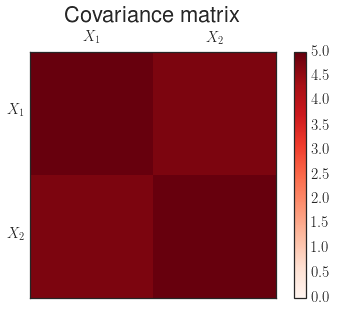

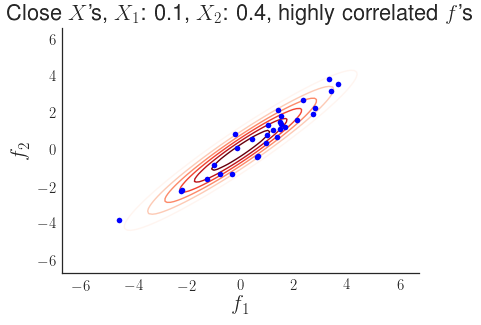

In [4]:
#Define the prior range
res = 100
def make_prior(fs_mean, fs_cov, X, ind_1=0, ind_2=1):
    f1s_min = float(fs_mean[ind_1] - 3*np.sqrt(fs_cov[ind_1,ind_1]))
    f1s_max = float(fs_mean[ind_1] + 3*np.sqrt(fs_cov[ind_1,ind_1]))
    f2s_min = float(fs_mean[ind_2] - 3*np.sqrt(fs_cov[ind_2,ind_2]))
    f2s_max = float(fs_mean[ind_2] + 3*np.sqrt(fs_cov[ind_2,ind_2]))
    f1s_range = np.linspace(f1s_min, f1s_max, res)
    f2s_range = np.linspace(f2s_min, f2s_max, res)
    f12_x, f12_y = np.meshgrid(f1s_range, f2s_range)

    #f1 and f2 locations (possible X1's and X2's) in tuple form 
    f12 = np.vstack((f12_x.flatten(), f12_y.flatten())).T

    #Zero mean
    f12_mean = np.zeros_like(fs_mean[:2])

    #Covariance is just covariance between f1 and f2 under our kernel
    ff12 = np.vstack((X[ind_1], X[ind_2]))
    f12_cov = kern.K(ff12)
    f12_cov += np.eye(f12_cov.shape[0])*1e-5

    #Compute the probably density of each X1 and X2 pairing pairing
    f12_prior = multivariate_normal_pdf(f12, f12_mean, f12_cov).reshape(res,res)
    return f12, f12_x, f12_y, f12_prior, f12_cov, f1s_min, f2s_min, f1s_max, f2s_max

f12, f12_x, f12_y, f12_prior, f12_cov, _, _, _, _ = make_prior(fs_mean, fs_cov, X_f, ind_1=0, ind_2=1)
#Show the kernel
fig, ax = plt.subplots(1)
alpha = ['$X_{1}$', '$X_{2}$']
#cmap = sns.sequential_palette("GnBu_d", as_cmap=True)
cax =  ax.matshow(f12_cov, vmin=0, vmax=variance, cmap="Reds")
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
#plt.xlabel('$X_1$', fontsize=label_fontsize)
#plt.ylabel('$X_2$', fontsize=label_fontsize)
fig.colorbar(cax)
plt.title('Covariance matrix', fontsize=label_fontsize,y=1.1)
if save:
    plt.savefig('{}/correlated_f_matrix.pdf'.format(fig_dir), bbox_inches='tight')

#Show the prior
plt.figure()
plt.contour(f12_x, f12_y, f12_prior, cmap="Reds")
plt.plot(f1s, f2s, 'bo')
plt.xlabel('$f_{1}$', fontsize=label_fontsize)
plt.ylabel('$f_{2}$', fontsize=label_fontsize)
plt.title("Close $X$'s, $X_1$: {}, $X_2$: {}, highly correlated $f$'s".format(np.float(X_f1),np.float(X_f2)), fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/correlated_f_samples.pdf'.format(fig_dir), bbox_inches='tight')

## Sample uncorrelated

In [5]:
samples = 30
f2s, f3s = np.random.multivariate_normal(fs_mean[1:], fs_cov[1:,1:], samples).T

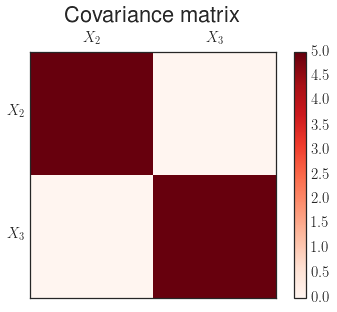

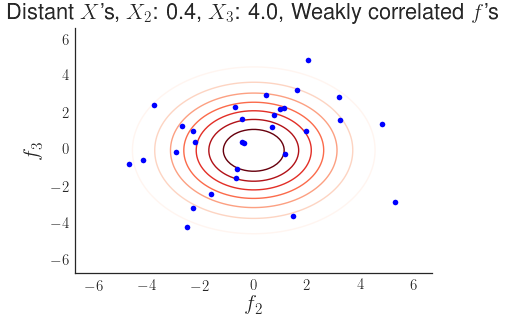

In [6]:
#f2s_min = float(fs_mean[1] - 3*np.sqrt(cov[1,1]))
#f2s_max = float(fs_mean[1] + 3*np.sqrt(cov[1,1]))
#f3s_min = float(fs_mean[2] - 3*np.sqrt(cov[2,2]))
#f3s_max = float(fs_mean[2] + 3*np.sqrt(cov[2,2]))
#f2s_range = np.linspace(f2s_min, f2s_max, res)
#f3s_range = np.linspace(f3s_min, f3s_max, res)
#f23_x, f23_y = np.meshgrid(f2s_range, f3s_range)

##f2 and f3 locations (possible X1's and X2's) in tuple form 
#f23 = np.vstack((f23_x.flatten(), f23_y.flatten())).T

##Zero mean
#f23_mean = np.zeros_like(fs_mean[1:])

##Covariance is just covariance between f1 and f2 under our kernel
#ff23 = np.vstack((X2, X3))
#f23_cov = kern.K(ff23)
#f23_cov += np.eye(f23_cov.shape[0])*1e-5

##Compute the probably density of each X2 and X3 pairing pairing
#f23_prior = multivariate_normal_pdf(f23, f23_mean, f23_cov).reshape(res,res)

f23, f23_x, f23_y, f23_prior, f23_cov, _, _, _, _ = make_prior(fs_mean, fs_cov, X_f, ind_1=1, ind_2=2)

fig, ax = plt.subplots(1)
alpha = ['$X_{2}$', '$X_{3}$']
#Show the kernel
cax = ax.matshow(f23_cov, vmin=0.0, vmax=variance, cmap="Reds")
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
#plt.xlabel('$X_1$', fontsize=label_fontsize)
#plt.ylabel('$X_2$', fontsize=label_fontsize)
fig.colorbar(cax)
plt.title('Covariance matrix', fontsize=label_fontsize,y=1.1)

if save:
    plt.savefig('{}/uncorrelated_f_matrix.pdf'.format(fig_dir), bbox_inches='tight')

#Show prior
plt.figure()
plt.contour(f23_x, f23_y, f23_prior, cmap="Reds")
plt.plot(f2s, f3s, 'bo')
plt.xlabel('$f_2$', fontsize=label_fontsize)
plt.ylabel('$f_3$', fontsize=label_fontsize)
plt.title("Distant $X$'s, $X_2$: {}, $X_3$: {}, Weakly correlated $f$'s".format(np.float(X_f2),np.float(X_f3)), fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/uncorrelated_f_samples.pdf'.format(fig_dir), bbox_inches='tight')

## The likelihood

The likelihood usually says that each data point is independent, and reliant only on a single latent variable $\mathbf{f}_{i}$, from which the observed value was a corrupted version.
$$\prod_{i=1}^{n} p(\mathbf{y}_{i}|\mathbf{f}_{i})$$
The likelihood is usually in a Gaussian Process assumed to be Gaussian, which means that the posterior is simply a Gaussian. In other cases this assumption may not be valid.

Intuitively the likelihood component of the model assumes that you will not see a non-corrupted version of the real underlying function producing the data, and the corrupted version you see could come from any different probability distribution, for example if it was count data we would say the data we observed for how many counts there were could have only been positive integer values, and the the smaller the rate at which they are happening the smaller the variance in the values we could have seen, and the number we observed is likely to be closer to the real number. If the rate is high and we are observing large numbers of events, then the variance is larger and closer to a Gaussian distribution, where we are only observing integers.

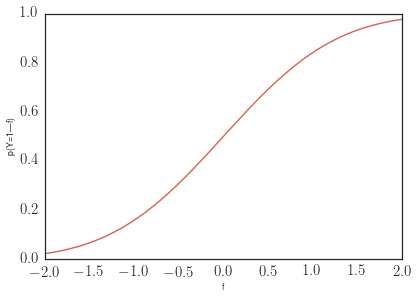

In [28]:
#Redefine prior to make it wide to increase sharpness of likelihood
kern = GPy.kern.RBF(1, variance=80.0)
fs_cov = kern.K(X_f)
fs_mean = np.zeros(fs_cov.shape[0])
f12, f12_x, f12_y, f12_prior, f12_cov, f1s_min, f2s_min, f1s_max, f2s_max = make_prior(fs_mean, fs_cov, X_f, ind_1=0, ind_2=1)

def inv_logit(f):
    return np.exp(f) / (1 + np.exp(f))

def inv_probit(f, sharpness_param=1):
    return 0.5*(1+sp.special.erf((f*sharpness_param)/np.sqrt(2)))
    
def class_likelihood(y, f):
    return (inv_probit(f)**y) * (1 - inv_probit(f))**(1-y)

f = np.linspace(-2,2,res)[:, None]
Y = np.ones_like(f)
plt.plot(f, class_likelihood(Y,f))
plt.xlabel('f')
plt.ylabel('p(Y=1|f)')

Lets look at the posterior where we only have 2 data, $y_{1}$ and $y_{2}$, i.e. we are only looking at two $f$'s, $f_{1}$ and $f_{2}$

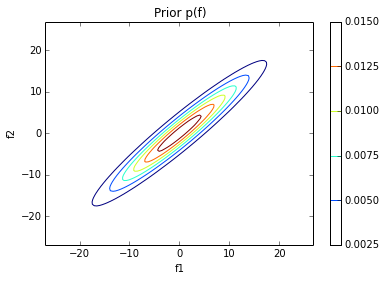

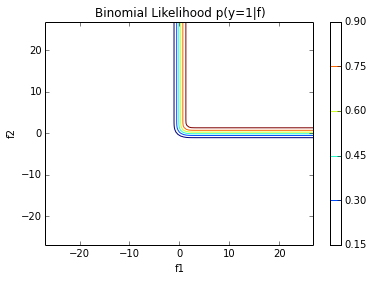

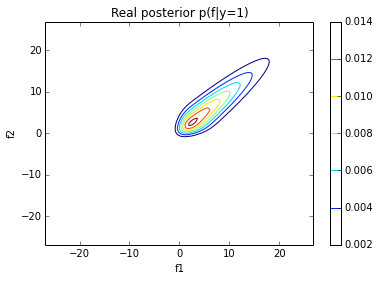

In [42]:
plt.figure()
plt.contour(f12_x, f12_y, f12_prior)
plt.colorbar()
plt.title('Prior p(f)')
plt.xlabel('f1')
plt.ylabel('f2')
if save:
    plt.savefig('{}/Gaussian_prior.pdf'.format(fig_dir), bbox_inches='tight')

Y = np.ones_like(f12)
like_f12 = (class_likelihood(Y[:,0], f12[:,0]) * class_likelihood(Y[:,1], f12[:,1]))
like_f12 = like_f12.reshape(res,res)
plt.figure()
plt.contour(f12_x, f12_y, like_f12)
plt.colorbar()
plt.title('Binomial Likelihood p(y=1|f)')
plt.xlabel('f1')
plt.ylabel('f2')
if save:
    plt.savefig('{}/Binomial_likelihood.pdf'.format(fig_dir), bbox_inches='tight')

plt.figure()
#Unnormalised posterior = prior * likelihood
post_f12 = f12_prior * like_f12
#Normalise
post_f12 /= post_f12.sum()
post_f12 /= np.diff(f12_x, axis=1)[0,0]**2

plt.contour(f12_x, f12_y, post_f12)
plt.colorbar()
plt.title('Real posterior p(f|y=1)')
plt.xlabel('f1')
plt.ylabel('f2')
if save:
    plt.savefig('{}/Binomial_Posterior.pdf'.format(fig_dir), bbox_inches='tight')

## The Laplace approximation

The posterior listed above is clearly non-Gaussian. To calculate the predictive distribution amongst other things we require an approximation to the posterior as Gaussian distribution. There are a multitude of approximation routines available, each with their own strengths and pitfalls. The most simple is argubly the Laplace Approximation. In this approximation we look at the mode of the marginals and use the curvature of this and use a Gaussian approximation which shares the same curvature at its mode.

This approximation works well when the mode of the marginals are descriptive of the entire marginal distribution, and less effective when this is not the case.

We will start by looking at the effect with the Binomial likelihood with a Probit link function, where we observe positive data.

### Classification

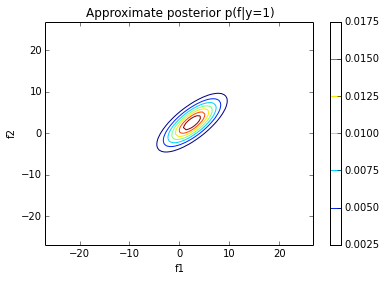

In [43]:
post_color = 'k'
approx_color= '#CC6600'

Y=np.ones_like(X_f)
laplace = GPy.inference.latent_function_inference.Laplace()
likelihood = GPy.likelihoods.bernoulli.Bernoulli(gp_link=GPy.likelihoods.link_functions.Probit())
post, log_marginal, grads = laplace.inference(kern, X_f, likelihood, Y)
mode = post.mean
covar = post.covariance
approx = multivariate_normal_pdf(f12, mode[:2].T, covar[:2, :2]).reshape(res, res)

approx /= approx.sum()
approx /= np.diff(f12_x,axis=1)[0,0]**2
plt.contour(f12_x, f12_y, approx)
plt.colorbar()
plt.title('Approximate posterior p(f|y=1)')
plt.xlabel('f1')
plt.ylabel('f2')
if save:
    plt.savefig('{}/Binomial_approx.pdf'.format(fig_dir), bbox_inches='tight')

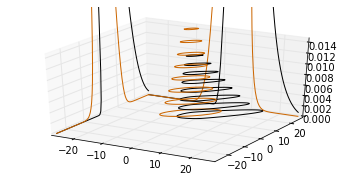

In [44]:
ax = plt.subplot2grid((4,3),(1,0), colspan=3, rowspan=3, projection='3d')

#Plot Real posterior and marginals
contours = np.linspace(0, post_f12.max(), 10)[1:]
ax.contour(f12_x, f12_y, post_f12, contours, colors=post_color)

marg = post_f12.sum(0)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f1s_min, zdir='x', color=post_color)

marg = post_f12.sum(1)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f2s_max, zdir='y', color=post_color)

#Plot laplace approximation and marginals
contours = np.linspace(0, approx.max(), 10)[1:]
ax.contour(f12_x, f12_y, approx, contours, colors=approx_color)

marg = approx.sum(0)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f1s_min, zdir='x', color=approx_color)

marg = approx.sum(1)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f2s_max, zdir='y', color=approx_color)

ax.set_zlim([0,post_f12.max()])
if save:
    plt.savefig('{}/Binomial_3d.pdf'.format(fig_dir), bbox_inches='tight')

### Poisson likelihood

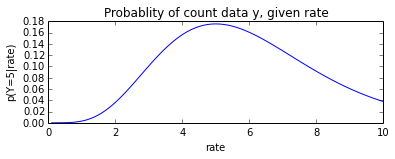

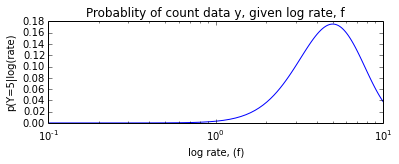

In [45]:
#Redefine prior to make it a sensible prior
kern = GPy.kern.RBF(1, variance=1.0)
fs_cov = kern.K(X_f)
fs_mean = np.zeros(fs_cov.shape[0])
f12, f12_x, f12_y, f12_prior, f12_cov, f1s_min, f2s_min, f1s_max, f2s_max = make_prior(fs_mean, fs_cov, X_f, ind_1=0, ind_2=1)

#Repeat for Poisson
def poisson_likelihood(y, rate):
    return GPy.likelihoods.Poisson(gp_link=GPy.likelihoods.link_functions.Identity()).pdf(rate, y)

def poisson_likelihood_log_rate(y, log_rate):
    return GPy.likelihoods.Poisson().pdf(log_rate, y)
    
k=5
f = np.linspace(0, k*2,res)[:, None]
#To plot as a function of f, keep data the same for each f
Y = np.ones_like(f)*k
p_y_f = np.array([poisson_likelihood(Y[ind],f[ind]) for ind in range(f.shape[0])])

#f = log(rate) where f is the latent value of the GP

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(f, p_y_f)
ax1.set_xlabel('rate')
ax1.set_ylabel('p(Y={}|rate)'.format(k))
ax1.set_title('Probablity of count data y, given rate ')

fig = plt.figure()
ax2 = fig.add_subplot(2,1,2)
ax2.semilogx(f, p_y_f)
ax2.set_xlabel('log rate, (f)')
ax2.set_ylabel('p(Y={}|log(rate)'.format(k))
ax2.set_title('Probablity of count data y, given log rate, f')

In [46]:
#Use to work in the rate space then plot in the log space, now longer needed as we work in the log rate space, f
#Make it so the range of rates (not really f) are positive
#f1s_range = np.linspace(0.01, f1s_max, res)
#f2s_range = np.linspace(0.01, f2s_max, res)
#f12_x, f12_y = np.meshgrid(f1s_range, f2s_range)

#f1 and f2 locations (possible X1's and X2's) in tuple form 
#f12 = np.vstack((f12_x.flatten(), f12_y.flatten())).T

#Covariance is just covariance between f1 and f2 under our kernel
#ff12 = np.vstack((X1, X2))
#f12_cov = kern.K(ff12)
#f12_cov += np.eye(f12_cov.shape[0])*1e-5

#Compute the probably density of each X1 and X2 pairing pairing
#f12_prior = multivariate_normal_pdf(f12, f12_mean, f12_cov).reshape(res,res)

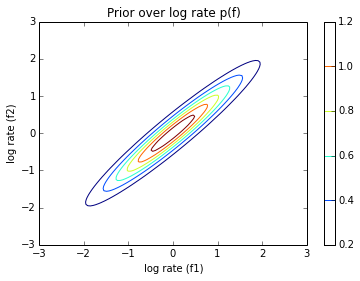

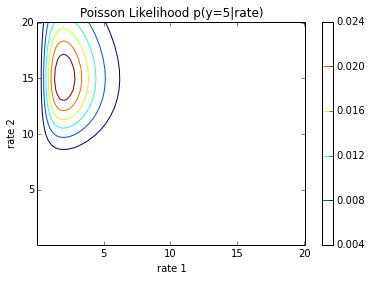

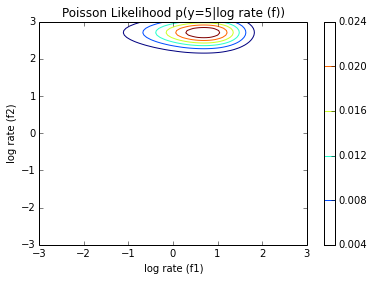

In [47]:
#Prior over f, in the log rate space
plt.figure()
plt.contour(f12_x, f12_y, f12_prior)
plt.colorbar()
plt.title('Prior over log rate p(f)')
plt.xlabel('log rate (f1)')
plt.ylabel('log rate (f2)')
if save:
    plt.savefig('{}/Gaussian_prior_poisson.pdf'.format(fig_dir), bbox_inches='tight')

#Explore what happens when we change the data, the data is then implying that the rate is very different
#For the two datum
Y = np.array([2,15,80])[:, None]

like_f12 = np.array([poisson_likelihood_log_rate(Y[:2].flatten(),f12[ind,:]) for ind in range(f12.shape[0])])
#PMF of negative f's are not defined, treat them as 0
#like_f12 = np.nan_to_num(like_f12)

like_f12 = like_f12.reshape(res,res)

#Likelihood in terms of rate (positive)
fig = plt.figure()
ax = fig.add_subplot(111)
#Exponentiate to put f back in the "rate space"
c = ax.contour(np.exp(f12_x), np.exp(f12_y), like_f12)
fig.colorbar(c)
ax.set_title('Poisson Likelihood p(y={}|rate)'.format(k))
ax.set_xlabel('rate 1')
ax.set_ylabel('rate 2')

#In terms of f (log rate, rate could be negative and it wouldnt matter)
fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.contour(f12_x, f12_y, like_f12)
fig.colorbar(c)
ax.set_title('Poisson Likelihood p(y={}|log rate (f))'.format(k))
ax.set_xlabel('log rate (f1)')
ax.set_ylabel('log rate (f2)')
if save:
    plt.savefig('{}/Poisson_likelihood.pdf'.format(fig_dir), bbox_inches='tight')
#ax.set_xscale('log')
#ax.set_yscale('log')

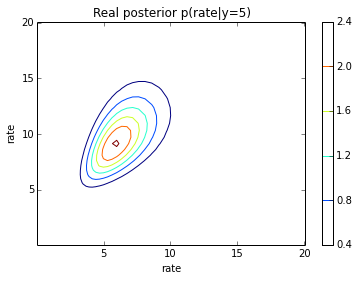

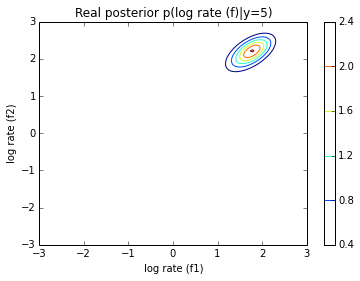

In [48]:
#Unnormalised posterior = prior * likelihood
post_f12 = f12_prior * like_f12
#Normalise
post_f12 /= post_f12.sum()
#What does this step do?
post_f12 /= np.diff(f12_x, axis=1)[0,0]**2

fig = plt.figure()
ax1 = fig.add_subplot(111)
#Exponentiate to put f back in the "rate space"
c = ax1.contour(np.exp(f12_x), np.exp(f12_y), post_f12)
fig.colorbar(c)
ax1.set_title('Real posterior p(rate|y={})'.format(k))
ax1.set_xlabel('rate')
ax1.set_ylabel('rate')

fig = plt.figure()
ax2 = fig.add_subplot(111)
c = ax2.contour(f12_x, f12_y, post_f12)
fig.colorbar(c)
ax2.set_title('Real posterior p(log rate (f)|y={})'.format(k))
ax2.set_xlabel('log rate (f1)')
ax2.set_ylabel('log rate (f2)')
if save:
    plt.savefig('{}/Poisson_posterior.pdf'.format(fig_dir), bbox_inches='tight')

Now we make a laplace approximation to the posterior

In [49]:
laplace = GPy.inference.latent_function_inference.Laplace()
#Modelling the rate in the log space, f
likelihood = GPy.likelihoods.poisson.Poisson()

post, log_marginal, grads = laplace.inference(kern, X_f, likelihood, Y)
mode = post.mean
covar = post.covariance

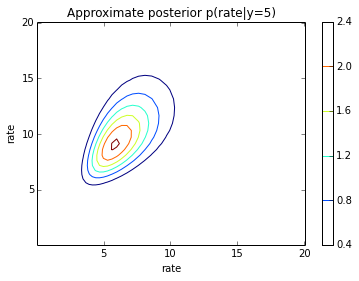

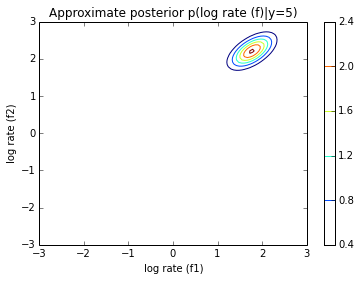

In [50]:
approx = multivariate_normal_pdf(f12, mode[:2].T, covar[:2, :2]).reshape(res, res)
approx /= approx.sum()
approx /= np.diff(f12_x,axis=1)[0,0]**2

#Posterior over the log of the rate is Gaussian
fig = plt.figure()
ax1 = fig.add_subplot(111)
#Exponentiate scale to put f back in the "rate space"
c = ax1.contour(np.exp(f12_x), np.exp(f12_y), approx)
fig.colorbar(c)
ax1.set_title('Approximate posterior p(rate|y={})'.format(k))
ax1.set_xlabel('rate')
ax1.set_ylabel('rate')

#Posterior over the log of the rate is Gaussian
fig = plt.figure()
ax1 = fig.add_subplot(111)
c = ax1.contour(f12_x, f12_y, approx)
fig.colorbar(c)
ax1.set_title('Approximate posterior p(log rate (f)|y={})'.format(k))
ax1.set_xlabel('log rate (f1)')
ax1.set_ylabel('log rate (f2)')

if save:
    plt.savefig('{}/Poisson_approx.pdf'.format(fig_dir), bbox_inches='tight')


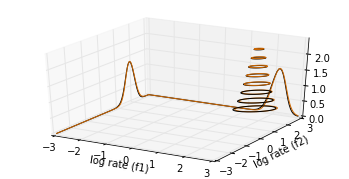

In [51]:
ax = plt.subplot2grid((4,3),(1,0), colspan=3, rowspan=3, projection='3d')
ax.set_xlabel('log rate (f1)')
ax.set_ylabel('log rate (f2)')

#Plot Real posterior and marginals
contours = np.linspace(0, post_f12.max(), 10)[1:]
ax.contour(f12_x, f12_y, post_f12, contours, colors=post_color)

marg = post_f12.sum(0)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f1s_min, zdir='x', color=post_color)

marg = post_f12.sum(1)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f2s_max, zdir='y', color=post_color)

#Plot laplace approximation and marginals
contours = np.linspace(0, approx.max(), 10)[1:]
ax.contour(f12_x, f12_y, approx, contours, colors=approx_color)

marg = approx.sum(0)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f1s_min, zdir='x', color=approx_color)

marg = approx.sum(1)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(f12_x[1], marg, f2s_max, zdir='y', color=approx_color)

ax.set_zlim([0,post_f12.max()])

if save:
    plt.savefig('{}/Poisson_3d.pdf'.format(fig_dir), bbox_inches='tight')

(0, 2.4462229465920942)

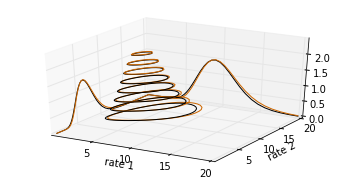

In [52]:
#Same marginal plots but in exponential (rate) space
ax = plt.subplot2grid((4,3),(1,0), colspan=3, rowspan=3, projection='3d')
ax.set_xlabel('rate 1')
ax.set_ylabel('rate 2')

#Plot Real posterior and marginals
contours = np.linspace(0, post_f12.max(), 10)[1:]
ax.contour(np.exp(f12_x), np.exp(f12_y), post_f12, contours, colors=post_color)

marg = post_f12.sum(0)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(np.exp(f12_x[1]), marg, np.exp(f1s_min), zdir='x', color=post_color)

marg = post_f12.sum(1)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(np.exp(f12_x[1]), marg, np.exp(f2s_max), zdir='y', color=post_color)

#Plot laplace approximation and marginals
contours = np.linspace(0, approx.max(), 10)[1:]
ax.contour(np.exp(f12_x), np.exp(f12_y), approx, contours, colors=approx_color)

marg = approx.sum(0)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(np.exp(f12_x[1]), marg, np.exp(f1s_min), zdir='x', color=approx_color)

marg = approx.sum(1)
marg /= marg.sum()
marg /= (f12_x[0][1] - f12_x[0][0])
ax.plot(np.exp(f12_x[1]), marg, np.exp(f2s_max), zdir='y', color=approx_color)

ax.set_zlim([0,post_f12.max()])

# Why aren't the marginals matching the posterior?!

## Kernel functions

Different kernel functions give different assumptions about the function we are trying to model, rbf assumes smoothness, linear assumed linearity, periodic assumes periodicity, matern assumes differentiability, polynomial assumes the function is some order polynomial, browning assumes lack of differentiabity, bias assumes an offset. Below we show examples of samples from some of the many kernel functions implemented, giving a visual idea about what each of these different prior assumptions are making about the function.

 /Users/alansaul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/alansaul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/alansaul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/alansaul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/alansaul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:82: RuntimeWarning:covariance is not positive-semidefinite.


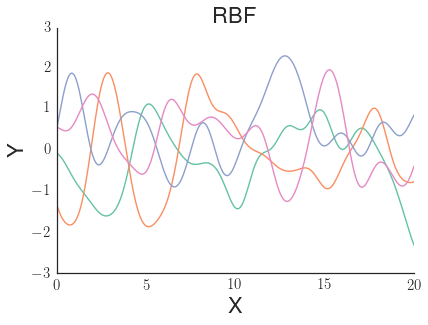

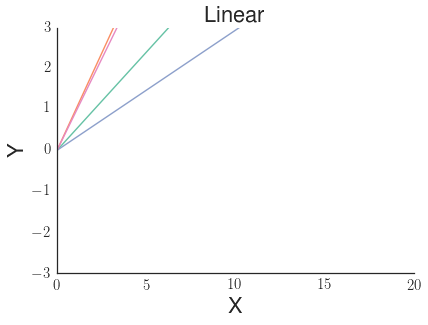

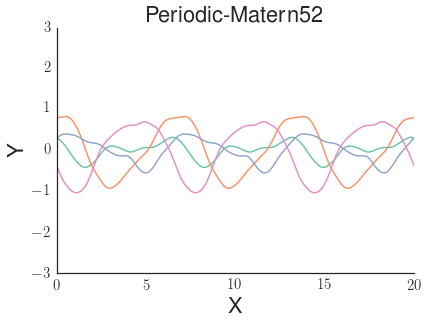

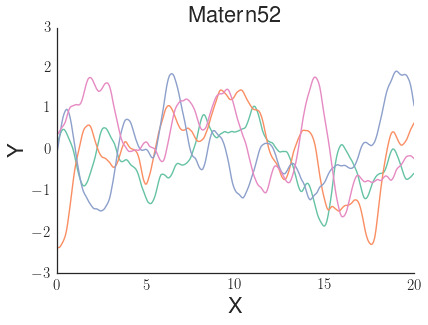

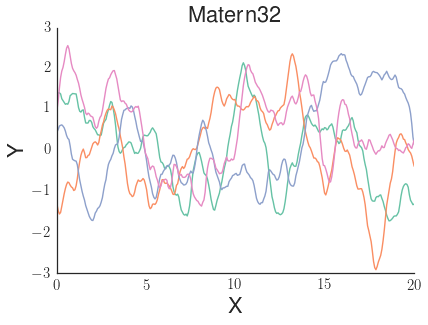

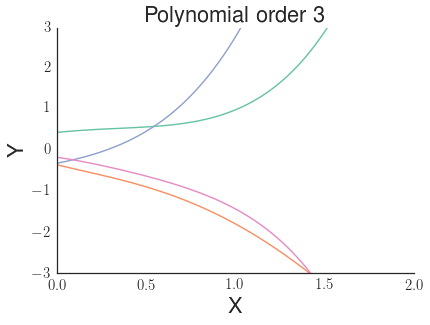

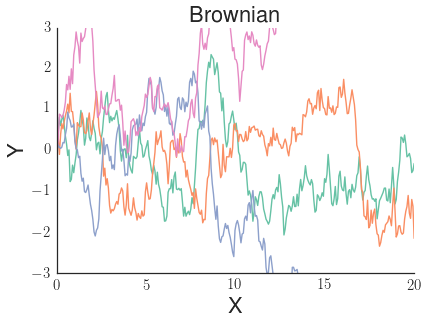

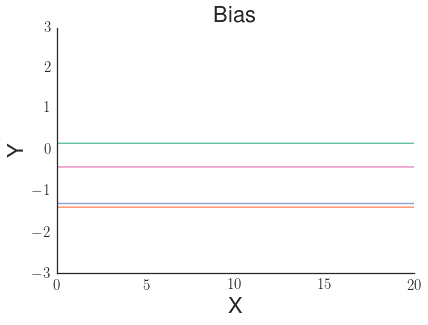

In [34]:
num_samples = 4
X = np.linspace(0,20, 300)[:, None]
X_poly = np.linspace(0,2,300)[:,None]

Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.RBF(1).K(X), num_samples).T
plt.plot(X,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('RBF', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/RBF_sample.pdf'.format(fig_dir), bbox_inches='tight')

Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.Linear(1).K(X), num_samples).T
plt.figure()
plt.plot(X,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('Linear', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/Linear_sample.pdf'.format(fig_dir), bbox_inches='tight')
    
Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.PeriodicMatern52(1, lengthscale=3, variance=5, period=X.max()/3).K(X), num_samples).T
plt.figure()
plt.plot(X,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('Periodic-Matern52', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/Perioid52_sample.pdf'.format(fig_dir), bbox_inches='tight')

Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.Matern52(1).K(X), num_samples).T
plt.figure()
plt.plot(X,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('Matern52', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/Matern52_sample.pdf'.format(fig_dir), bbox_inches='tight')
    
Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.Matern32(1).K(X), num_samples).T
plt.figure()
plt.plot(X,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('Matern32', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/Matern32_sample.pdf'.format(fig_dir), bbox_inches='tight')


Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.Poly(1, variance=0.2, order=4).K(X_poly), num_samples).T
plt.figure()
plt.plot(X_poly,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('Polynomial order 3', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/Polynomial_sample.pdf'.format(fig_dir), bbox_inches='tight')
    
Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.Brownian(1).K(X), num_samples).T
plt.figure()
plt.plot(X,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('Brownian', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/Brownian_sample.pdf'.format(fig_dir), bbox_inches='tight')
    
Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), GPy.kern.Bias(1).K(X), num_samples).T
plt.figure()
plt.plot(X,Y)
plt.ylim(-3,3)
plt.xlabel('X', fontsize=label_fontsize)
plt.ylabel('Y', fontsize=label_fontsize)
plt.title('Bias', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/Bias_sample.pdf'.format(fig_dir), bbox_inches='tight')

These kernels can be combined in a variety of ways

Now lets look at what the GP is doing, by plotting samples from the prior and the posterior

 /Users/alansaul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/alansaul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning:covariance is not positive-semidefinite.


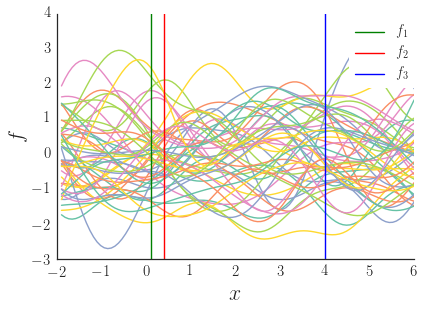

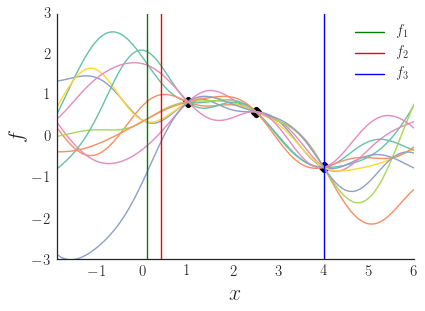

In [33]:
def rbf(X1, X2):
    return np.exp(-0.5*((X1-X2.T)**2))
old_f_locations = X.copy()
X = np.linspace(X_f.min()-2, X_f.max()+2, 100)[:, None]
K = rbf(X, X)
#Plot prior
F = np.random.multivariate_normal(np.zeros(X.shape[0]), K, 50)
plt.figure(1)
plt.plot(X, F.T)
plt.axvline(X_f[0], F.min(), F.max(), label='$f_1$', c='g')
plt.axvline(X_f[1], F.min(), F.max(), label='$f_2$', c='r')
plt.axvline(X_f[2], F.min(), F.max(), label='$f_3$', c='b')
leg = plt.legend(fontsize=label_fontsize/1.5, frameon=True, bbox_to_anchor=(1.02, 1.00))
leg.get_frame().set_linewidth(0.0)
plt.ylabel('$f$', fontsize=label_fontsize)
plt.xlabel('$x$', fontsize=label_fontsize)
sns.despine()


if save:
    plt.savefig('{}/gp_prior_samples.pdf'.format(fig_dir), bbox_inches='tight')

X_real_loc = np.array([1, 2.5, 4])[:, None]
X = np.sin(X_real_loc)
K = rbf(X, X)
X_test_loc = np.linspace(X_f.min()-2, X_f.max()+2, 100)[:, None]
K = rbf(X_real_loc, X_real_loc)
Ks = rbf(X_real_loc, X_test_loc)
Kss = rbf(X_test_loc, X_test_loc)
Ki = np.linalg.inv(K)
mean = np.dot(Ks.T, np.dot(Ki, X))
mean = np.squeeze(mean)
cov = Kss - np.dot(Ks.T, np.dot(Ki, Ks))
Fs = np.random.multivariate_normal(mean, cov, 10)
plt.figure(2)
#plt.hold(True)
plt.scatter(X_real_loc, X, marker='D', linewidths=5)
plt.plot(X_test_loc, Fs.T)
plt.axvline(X_f[0], F.min(), F.max(), label='$f_1$', c='g')
plt.axvline(X_f[1], F.min(), F.max(), label='$f_2$', c='r')
plt.axvline(X_f[2], F.min(), F.max(), label='$f_3$', c='b')

leg = plt.legend(fontsize=label_fontsize/1.5, frameon=True, bbox_to_anchor=(1.02, 1.00))
leg.get_frame().set_linewidth(0.0)

plt.axis([X_f.min()-2, X_f.max()+2, -3, 3])
plt.ylabel('$f$', fontsize=label_fontsize)
plt.xlabel('$x$', fontsize=label_fontsize)
sns.despine()
if save:
    plt.savefig('{}/gp_fit.pdf'.format(fig_dir), bbox_inches='tight')